# Traffic Light Detection On Oriented Imagery Using Pre-Trained Model

> * 🔬 Data Science
> * 🥠 Deep Learning and Object classification

## Table of Contents
* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Download & setting up data](#Download-&-setting-up-data)
* [Load YoloV3 model](#Load-YoloV3-model)
* [YoloV3 Model inference](#YoloV3-Model-inference)
* [Relative Depth Estimation Model](#Relative-Depth-Estimation-Model)
* [Extract Location Of Traffic Lights On Map](#Extract-Location-Of-Traffic-Lights-On-Map)
* [Results](#Results)
* [Conclusion](#Conclusion)

## Introduction

In this sample notebook we will be using `ArcGIS API for Python` for using a pre-trained deep learning model for object detection on oriented imagery data.  
We will be using the pre-trained YOLO model which is trained on [COCO dataset](https://cocodataset.org/#home) which is a publicly available large-scale object detection, segmentation, and captioning dataset.
This dataset has 1000 classes out of which one class is <b>traffic light</b>. Using this model we will try to detect traffic lights in the oriented imagery.

## Necessary imports

In [2]:
import os, json, cv2
from math import *
import numpy as np
import itertools
import pandas as pd
import zipfile
from pathlib import Path

<IPython.core.display.Javascript object>

In [3]:
import arcgis, arcpy
from arcgis import GIS
from arcgis.geometry import Point
from arcgis.learn import YOLOv3

<IPython.core.display.Javascript object>

## Download & setting up data

We will need oriented imagery and oriented imagery meta data file so that we can use that for inferecing and plotting the points. We have sample images uploaded on [Python API Playground](https://pythonapi.playground.esri.com/portal). We will download those items below and use those for our workflow.

In [4]:
gis = GIS(
    "https://pythonapi.playground.esri.com/portal",
    "arcgis_python",
    "amazing_arcgis_123",
)

<IPython.core.display.Javascript object>

In [5]:
oriented_imagery_data = gis.content.get("5527b979e9cf4131b484fcd4eecbf2fc")
oriented_imagery_data

<Item title:"Oriented Imagery Sample Data" type:Image Collection owner:api_data_owner>

<IPython.core.display.Javascript object>

In [6]:
filepath = oriented_imagery_data.download(save_path = os.getcwd(), file_name=oriented_imagery_data.name)

<IPython.core.display.Javascript object>

In [7]:
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

After the extraction of the zip file we will set the path of the items which are there in the zip file which we will use in this workflow.
- `data_path`: Folder containing all the oriented imagery.
- `image_meta_data` : File containing meta data for all the oriented images in the data_path.
- `depth_image_path` : Folder containing all the relative estimated depth image of oriented imagery.


In [7]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]), "street_view_data")
image_meta_data = Path(os.path.join(os.path.splitext(filepath)[0]), "oriented_imagery_meta_data.csv")
depth_image_path = Path(os.path.join(os.path.splitext(filepath)[0]), "saved_depth_image")

<IPython.core.display.Javascript object>

In [8]:
image_path_list = [os.path.join(data_path, image) for image in os.listdir(data_path)]

<IPython.core.display.Javascript object>

## Load YoloV3 model

Since we will be using the pre-trained YOLO model so we will pass `pretrained_backbone` as `True`. In this way while initiaizing the YOLO model the pre trained weights of the YOLO model with COCO dataset will be downloaded. We will later using these weights to detect traffic lights.

In [9]:
yolo = YOLOv3(pretrained_backbone=True)

<IPython.core.display.Javascript object>

## YoloV3 Model inference

Once we have the model loaded and ready for inferencing we will be create a function named `traffic_light_finder` that will take orineted image as input and will return 2 things. 
- Json containing traffic lights coordinates
- Traffic lights annotated image

We will save all the Traffic lights annotated image into a folder and save all the annotations in a combined json file on the disk.

In [10]:
def traffic_light_finder(oriented_image_path):
    flag = 0
    coordlist = []
    temp_list = {}
    out = yolo.predict(oriented_image_path, threshold=0.5)
    test_img = cv2.imread(oriented_image_path)
    if len(out[0]) == 0:
        temp_list["object"] = False
    else:
        for index, (value, label, confidence) in enumerate(zip(out[0], out[1], out[2])):
            if label == "traffic light":
                flag = 1
                coordlist.append(
                    [int(value[0]), int(value[1]), int(value[2]), int(value[3])]
                )
                test_img = cv2.rectangle(
                    test_img,
                    (int(value[0]), int(value[1]), int(value[2]), int(value[3])),
                    (0, 0, 255),
                    10,
                )
                textvalue = label + "_" + str(confidence)
                cv2.putText(
                    test_img,
                    textvalue,
                    (int(value[0]), int(value[1]) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1.5,
                    (0, 0, 255),
                    2,
                )
        if flag == 1:
            temp_list["object"] = True
            temp_list["coords"] = coordlist
            temp_list["assetname"] = "traffic light"
    return temp_list, test_img

<IPython.core.display.Javascript object>

Here we will create a folder named <b>traffic_light_marked</b> which will contain all the images with traffic lights detected on them. We can use these images to check the output of the model. Later we can use them for our use case.

In [11]:
marked_image_saved_folder = os.path.join(os.getcwd(), "traffic_light_marked")
os.makedirs(marked_image_saved_folder, exist_ok=True)
marked_image_saved_folder

'D:\\TrafficSignalDataset\\sample\\traffic_light_marked'

<IPython.core.display.Javascript object>

In [ ]:
detections = {}
for e, image in enumerate(image_path_list):
    try:
        val_dict, out_image = traffic_light_finder(image)
        if bool(val_dict):
            detections[os.path.basename(image)] = val_dict
            cv2.imwrite(os.path.join(marked_image_saved_folder, os.path.basename(image)), out_image)
    except Exception as e:
        print(e)

Here we are also saving the coordinates of the traffic lights in a json file. We can use these coordinates to create a webmap or in any of the other use cases.

In [14]:
with open("traffic_light_data_sample.json", "w") as f:
    json.dump(detections, f)

<IPython.core.display.Javascript object>

Below are some of the images showcasing how the pre-trained YOLO model performs on the oriented imagery. 

<img src="../../static/img/oriented_image_yolo_output.gif" width="750" align="center">

## Relative Depth Estimation Model

We now have run the YoloV3 pretrained model on all the oriented images and got the coordinates of detected traffic lights in them.

We will now calculate the relative estimated depth of the objects in the oriented imagery. For that we have a pre-trainded model available from the Open-source [Bts-P|yTorch](https://github.com/ErenBalatkan/Bts-PyTorch) based on [From Big to Small: Multi-Scale Local Planar Guidance for Monocular Depth Estimation](https://arxiv.org/pdf/1907.10326.pdf).

We have packagaed the model as a dlpk file which we can use with ArcGIS Pro to calculate the relative estimated depth of the objects in the oriented imagery.

<Item title:"Relative Depth Estimation Model" type:Deep Learning Package owner:api_data_owner>
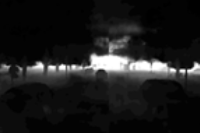

<IPython.core.display.Javascript object>

In [12]:
depth_model_item = gis.content.get("59656c114ece4a21bb0620435c7bf0b3")
depth_model_item

Once we have downloaded the dlpk file we will use it for calculating the estimated depth of the oriented images.

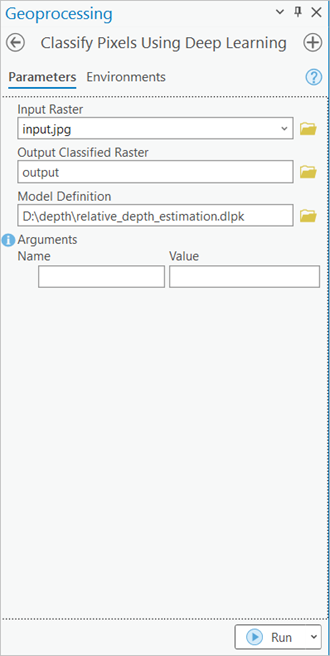

In [ ]:
with arcpy.EnvManager(processorType='cpu'):
    out_classified_raster = \
        arcpy.ia.ClassifyPixelsUsingDeepLearning(image_path_list[0],
            r"D:\sample\relative_depth_estimation.dlpk", None,
            'PROCESS_AS_MOSAICKED_IMAGE', None)
    out_classified_raster.save(r"D:\sample\samplename.png")

Below is the image showcasing how the pre-trained Relative Depth Estimation Model performs on the oriented imagery.

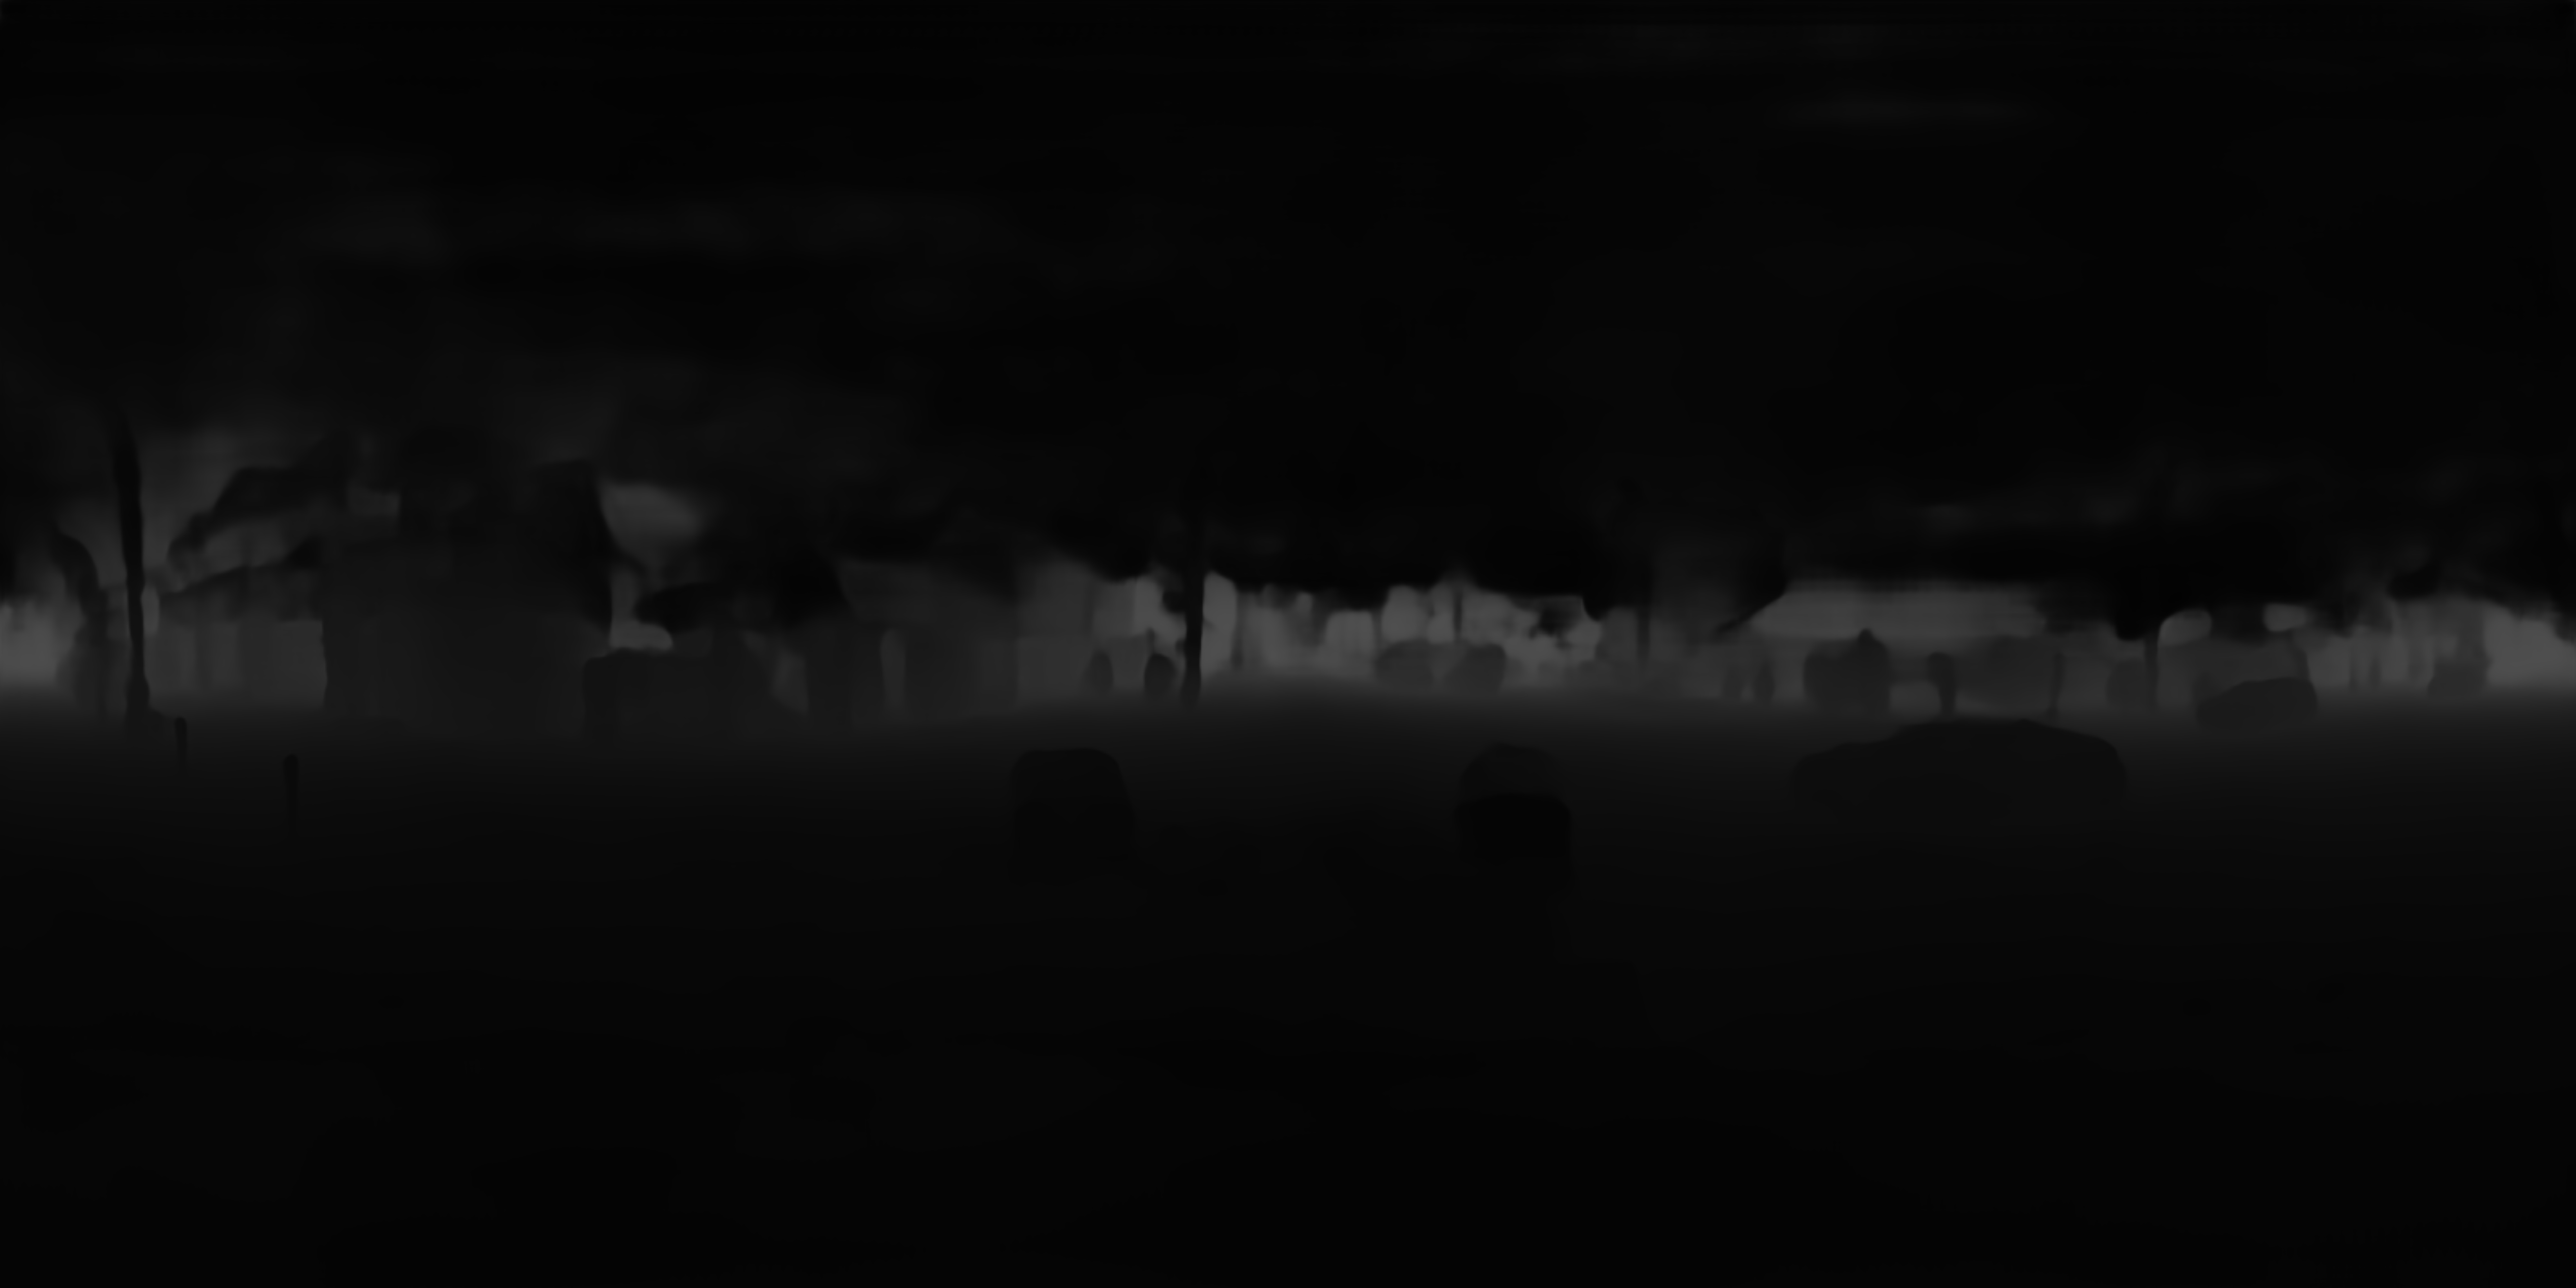

## Extract Location Of Traffic Lights On Map

We now have run the YoloV3 pretrained model on all the oriented images and got the coordinates of detected traffic lights in them. We now also have the relative estimated depth of objects in oriented imagery.

We also have an oriented image meta data file in csv format (downloaded above) which contains the meta data of the oriented imagery like the coordinate at which the image was taken, AvgHtAG, CamHeading, CamOri, HFOV, VFOV etc. You can understand more about these data points from this [document](https://www.esri.com/content/dam/esrisites/en-us/about/events/media/UC-2019/technical-workshops/tw-5765-872.pdf)

Using these data, now we will now try to find the exact location of the traffic lights on the map.

In [26]:
camera_df = pd.read_csv(image_meta_data)
camera_df.head()

,Unnamed: 0,AcquisitionDate,AvgHtAG,CamHeading,CamOri,CamPitch,CamRoll,FarDist,HFOV,Image,Name,NearDist,OBJECTID,OIType,SHAPE,VFOV
0,0,NaN,2.5,320.86540,3|3346||582715.827|6063651.438|111.212|-38.134...,88.64669,-1.58360,50.0,360.0,https://orientedimagerysamples.s3.amazonaws.co...,pano_000050_000371,1.0,26716,B,"{'x': 2814531.6957999994, 'y': 7304332.8588000...",180.0
1,1,NaN,2.5,358.02590,3|3346||582717.142|6063646.62|111.26|-0.97405|...,88.97281,-2.20641,50.0,360.0,https://orientedimagerysamples.s3.amazonaws.co...,pano_000050_000372,1.0,26717,B,"{'x': 2814533.810899999, 'y': 7304324.47829999...",180.0
2,2,NaN,2.5,6.04420,3|3346||582716.637|6063641.632|111.262|7.0442|...,88.89201,-3.11810,50.0,360.0,https://orientedimagerysamples.s3.amazonaws.co...,pano_000050_000373,1.0,26718,B,"{'x': 2814532.786800001, 'y': 7304315.84749999...",180.0
3,3,NaN,2.5,6.31495,3|3346||582716.017|6063636.642|111.284|7.31495...,88.85389,-3.14057,50.0,360.0,https://orientedimagerysamples.s3.amazonaws.co...,pano_000050_000374,1.0,26719,B,"{'x': 2814531.5621999986, 'y': 7304307.2359, '...",180.0
4,4,NaN,2.5,6.27997,3|3346||582715.377|6063631.674|111.302|7.27997...,88.77918,-3.34327,50.0,360.0,https://orientedimagerysamples.s3.amazonaws.co...,pano_000050_000375,1.0,26720,B,"{'x': 2814530.293200001, 'y': 7304298.6629, 's...",180.0


In [27]:
dets = list(detections.keys())

In [28]:
def find_intersection(
    x1,
    y1,
    x2,
    y2,
    x3,
    y3,
    x4,
    y4,
    ):
    px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3
          * x4)) / ((x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4))
    py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3
          * x4)) / ((x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4))
    return [px, py]


def process(input_list, threshold=(10, 10)):
    combos = itertools.combinations(input_list, 2)
    points_to_remove = [point2 for (point1, point2) in combos
                        if abs(point1[0] - point2[0]) <= threshold[0]
                        and abs(point1[1] - point2[1]) <= threshold[1]]
    points_to_keep = [point for point in input_list if point
                      not in points_to_remove]
    return points_to_keep

In [ ]:
OBJECT_HEIGHT_IN_WORLD = 0.9
(H, W, _) = cv2.imread(image_path_list[0]).shape
points = []

for i in range(len(dets) - 1):  # check coordinates of two consecutive images

    # load data of image1

    img1 = (dets[i])[:-4]
    cam1 = camera_df[camera_df['Name'] == img1].to_dict('records')[0]
    bboxes1 = detections[img1 + '.jpg']['coords']

    # load data of image2

    img2 = (dets[i + 1])[:-4]
    cam2 = camera_df[camera_df['Name'] == img2].to_dict('records')[0]
    bboxes2 = detections[img2 + '.jpg']['coords']

    for bbox1 in bboxes1:  # loop over all the bbox in image1
        if bbox1[3] > 50:  # ignore small bboxes

            # calculate the anngle of the object in image1

            direction_angle1 = cam1['CamHeading'] + cam1['HFOV'] / 2. \
                * (bbox1[0] + bbox1[2] / 2 - W / 2.) / (W / 2.)
            angle_subtended_by_object1 = cam1['VFOV'] * bbox1[3] / H

            # calculale the distance of object in image1 from center

            dist1 = OBJECT_HEIGHT_IN_WORLD \
                / tan(radians(angle_subtended_by_object1))
            dist1 = dist1 * pi

            # find coordinate of object in image1

            x12 = Point(eval(cam1['SHAPE']))['x'] + dist1 * cos(pi / 2
                    - radians(direction_angle1))
            y12 = Point(eval(cam1['SHAPE']))['y'] + dist1 * sin(pi / 2
                    - radians(direction_angle1))
            x11 = Point(eval(cam1['SHAPE']))['x']
            y11 = Point(eval(cam1['SHAPE']))['y']

            for bbox2 in bboxes2:  # loop over all the bbox in image2
                if bbox2[3] > 50:  # ignore small bboxes

                    # calculate the anngle of the object in image2

                    direction_angle2 = cam2['CamHeading'] + cam2['HFOV'
                            ] / 2. * (bbox2[0] + bbox2[2] / 2 - W / 2.) \
                        / (W / 2.)
                    angle_subtended_by_object2 = cam2['VFOV'] \
                        * bbox2[3] / H

                    # calculale the distance of object in image2 from center

                    dist2 = OBJECT_HEIGHT_IN_WORLD \
                        / tan(radians(angle_subtended_by_object2))
                    dist2 = dist2 * pi

                    # find coordinate of object in image2

                    x22 = Point(eval(cam2['SHAPE']))['x'] + dist2 \
                        * cos(pi / 2 - radians(direction_angle2))
                    y22 = Point(eval(cam2['SHAPE']))['y'] + dist2 \
                        * sin(pi / 2 - radians(direction_angle2))
                    x21 = Point(eval(cam2['SHAPE']))['x']
                    y21 = Point(eval(cam2['SHAPE']))['y']

                    # fin the point where coordinate from image1 and image2 intersect

                    pointval = find_intersection(
                        x11,
                        y11,
                        x12,
                        y12,
                        x21,
                        y21,
                        x22,
                        y22,
                        )

                    # load estimated depth image and select the mininum depth from the area where object is identified

                    (xmin, ymin, xmax, ymax) = (bbox2[0], bbox2[1],
                            bbox2[0] + bbox2[2], bbox2[1] + bbox2[3])
                    depth_image = \
                        cv2.imread(os.path.join(depth_image_path, img2
                                   + '.jpg'))
                    cropped_depth_image = depth_image[ymin:ymax, xmin:
                            xmax]

                    # take the estimated depth as distance from the center

                    DIST = np.min(cropped_depth_image[:, :, 0])
                    DIST = DIST + 7

                    # find coordinate of object using estimated depth as distance

                    x22_1 = Point(eval(cam2['SHAPE']))['x'] + DIST \
                        * cos(pi / 2 - radians(direction_angle2))
                    y22_1 = Point(eval(cam2['SHAPE']))['y'] + DIST \
                        * sin(pi / 2 - radians(direction_angle2))

                    point0 = np.array([float(pointval[0]),
                            float(pointval[1])])
                    point1 = np.array([float(x22_1), float(y22_1)])

                    # calculate euclidian distance between the point where coordinate from image1 and image2 intersect and  point calcuated using estimated depth

                    dist_points = np.linalg.norm(point0 - point1)

                    # if distance is less than 5 then take the point

                    if dist_points < 5:
                        points.append(pointval)

After the above mentioned process we have got some coordinates where there will be traffic lights but as one traffic light can be detected in multiple images therefore we will further cluster the data and take only one traffic light from a cluster.

In this way we will remove the redundant traffic light near a point.

In [36]:
print 'Number of traffic lights extracted - {}'.format(len(points))
outpoints = process(points)
print 'Number of traffic lights extracted after clustering and removing redundant traffic light - {}'.format(len(outpoints))

Number of traffic lights extracted - 302
Number of traffic lights extracted after clustering and removing redundant traffic light - 40


## Results 

We will load a map and draw the final selected coordinates on it. These coordinates are the places where there are traffic lights.

In [37]:
m = gis.map('Vilnius City')
m

MapView(layout=Layout(height='400px', width='100%'))

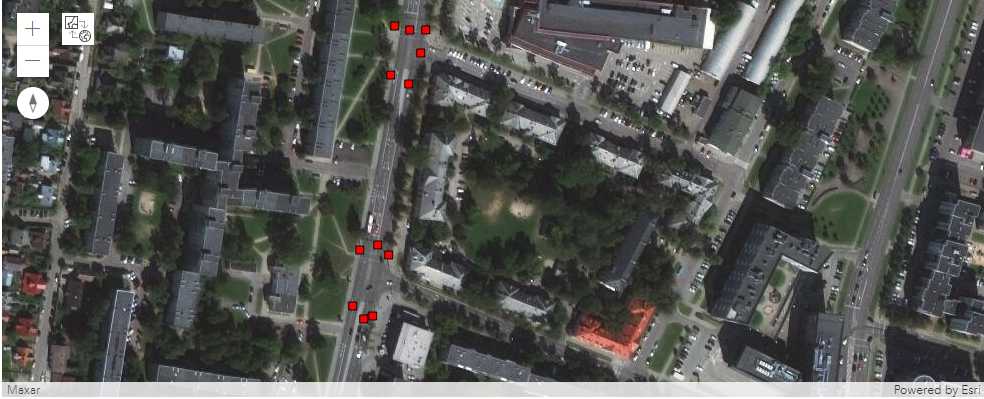

In [ ]:
m.center = {'x': 25.28489583988743, 'y': 54.70681816057357,
            'spatialReference': {'wkid': 4326, 'latestWkid': 4326}}
m.zoom = 19
m.basemap = 'satellite'

In [ ]:
for point in outpoints:
    intpoint = {'x': point[0], 'y': point[1],
                'spatialReference': {'wkid': 102100,
                'latestWkid': 3857}}
    m.draw(arcgis.geometry.Point(intpoint), symbol={
        'type': 'simple-marker',
        'style': 'square',
        'color': 'red',
        'size': '8px',
        })

## Conclusion 

In this notebook, we demonstrated how to use Oriented Imagery for deep learning workflow using `ArcGIS API for Python`.